In [5]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import lightning.pytorch as pl
import matplotlib.pyplot as plt
import ncg_optimizer as optim_ad
import seaborn as sns
from dataset import BdzDataset
from model import LitMLP
sns.set_theme()

In [ ]:
dtf = pd.read_csv('data/fsdata.csv')
train, val, test = np.split(dtf.sample(frac=1), [int(.6 * len(dtf)), int(.9 * len(dtf))])
train.shape, val.shape, test.shape

In [ ]:
train = BdzDataset(x=train.drop('class', axis=1), y=train['class'])
val = BdzDataset(x=val.drop('class', axis=1), y=val['class'])
test = BdzDataset(x=test.drop('class', axis=1), y=test['class'])

In [ ]:
from lightning.pytorch.callbacks import Callback
from lightning.pytorch.loggers import TensorBoardLogger


class MetricLogger(Callback):
    def __init__(self):
        super().__init__()
        self.train_metrics = []
        self.val_metrics = []
        self.test_metrics = []

    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        train_loss = trainer.callback_metrics['train_loss']
        self.train_metrics.append(train_loss.item())

    def on_validation_epoch_end(self, trainer, pl_module):
        val_loss = trainer.callback_metrics['val_loss']
        self.val_metrics.append(val_loss.item())

    def on_test_epoch_end(self, trainer, pl_module):
        test_loss = trainer.callback_metrics['test_loss']
        self.test_metrics.append(test_loss.item())
        
    def plot_loss(self):
        plt.plot(range(1, len(self.train_metrics) + 1),self.train_metrics , '-r', label='train')
        plt.plot(range(1, len(self.val_metrics) + 1), self.val_metrics, '-g', label='val')
        plt.legend(loc='upper right')
        plt.title('losses')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.show()

@torch.no_grad()
def init_weights(m):
     if type(m) == nn.Linear:
        nn.init.trunc_normal_(m.weight, std=100.0, a=0.0, b=100.0)

In [ ]:
def train_from_setup(setup, name):
    EPOCH = setup['epoch']
    lr = setup['lr']
    m = setup['m']
    opt = setup['opt']
    nesterov = setup['nesterov']
    bs = setup['bs']
    if bs == 0:
        tr = DataLoader(train, batch_size=train.__len__())
        vl = DataLoader(val, batch_size=val.__len__())
        tst = DataLoader(test, batch_size=test.__len__())
    else:
        tr = DataLoader(train, batch_size=bs)
        vl = DataLoader(val, batch_size=bs)
        tst = DataLoader(test, batch_size=test.__len__())
    
    logger = TensorBoardLogger("GD", name=name)
    metric = MetricLogger()
    model = LitMLP(input_dim=39, 
                   output_dim=2, 
                   lr=lr, 
                   nesterov=nesterov,
                   momentum=m,
                   opt=opt
                  )
    trainer = pl.Trainer(logger=logger, 
                         max_epochs=EPOCH,
                         callbacks=[metric])
    trainer.fit(model, tr, vl)
    trainer.test(model=model, dataloaders=tst)

In [ ]:
gdm_setup = [
    {'epoch':400, 'lr': 1e-1, "m": 0, "nesterov": False, 'bs': 0, 'opt': "SGD"},
    {'epoch': 300, 'lr': 1e-1, 'm': 0.9, "nesterov": False, 'bs': 0, 'opt': "SGD"},
    {'epoch': 300, 'lr': 1e-1, 'm': 0.8, "nesterov": False, 'bs': 0, 'opt': "SGD"},
    {'epoch': 300, 'lr': 1e-1, 'm': 0.4, "nesterov": False, 'bs': 0, 'opt': "SGD"},
]

nag_setup = [
    {'epoch': 300, 'lr': 1e-1, 'm': 0.9, "nesterov": True, 'bs': 0, 'opt': "SGD"},
    {'epoch': 300, 'lr': 1e-1, 'm': 0.8, "nesterov": True, 'bs': 0, 'opt': "SGD"},
    {'epoch': 300, 'lr': 1e-1, 'm': 0.4, "nesterov": True, 'bs': 0, 'opt': "SGD"},
]

In [ ]:
# GDM and NAG

for i in gdm_setup:
    train_from_setup(i, name='gdm')
    
for i in nag_setup:
    train_from_setup(i, name='nag')


In [ ]:
#Adagrad
adagrad = [
    {'epoch': 10, 'lr': 1e-3, "m": 0, "nesterov": False, 'bs': 50, 'opt': "Adagrad"},
]
for i in adagrad:
    train_from_setup(i, name='adagrad')


In [ ]:

# RMSprop and ADaDelta
rmsprop_setup = [
    {'epoch':10, 'lr': 1e-3, "m": 0, "nesterov": False, 'bs': 50, 'opt': "RMS"},
    {'epoch': 10, 'lr': 1e-3, 'm': 0.9, "nesterov": False, 'bs': 50, 'opt': "RMS"},
    {'epoch': 10, 'lr': 1e-3, 'm': 0.6, "nesterov": False, 'bs': 50, 'opt': "RMS"},
    {'epoch': 10, 'lr': 1e-3, 'm': 0.1, "nesterov": False, 'bs': 50, 'opt': "RMS"},
]

adadelta_setup = [
    {'epoch': 10, 'lr': 1e-3, 'm': 0, "nesterov": False, 'bs': 50, 'opt': "AdaDelta"},
    {'epoch': 10, 'lr': 1e-3, 'm': 0.9, "nesterov": False, 'bs': 50, 'opt': "AdaDelta"},
    {'epoch': 10, 'lr': 1e-3, 'm': 0.6, "nesterov": False, 'bs': 50, 'opt': "AdaDelta"},
    {'epoch': 10, 'lr': 1e-3, 'm': 0.4, "nesterov": False, 'bs': 50, 'opt': "AdaDelta"},
]



for i in rmsprop_setup:
    train_from_setup(i, name='rmsprop')
    
for i in adadelta_setup:
    train_from_setup(i, name='adadelta')



In [ ]:
#Adam
adam = [
    {'epoch': 7, 'lr': 1e-3, "m": [0.9, 0.999], "nesterov": False, 'bs': 50, 'opt': "Adam"},
    {'epoch': 7, 'lr': 1e-3, "m": [0.8, 0.888], "nesterov": False, 'bs': 50, 'opt': "Adam"},
    {'epoch': 7, 'lr': 1e-3, "m": [0.4, 0.9], "nesterov": False, 'bs': 50, 'opt': "Adam"},
    {'epoch': 7, 'lr': 1e-3, "m": [0.1, 0.2], "nesterov": False, 'bs': 50, 'opt': "Adam"},
]
for i in adam:
    train_from_setup(i, name='adam')

In [ ]:
#Rprop
rprop = [
    {'epoch': 100, 'lr': 1e-1, "m": 0, "nesterov": False, 'bs': 0, 'opt': "Rprop"}
]
for i in rprop:
    train_from_setup(i, name='rprop')

In [ ]:
#SGD
sgd = [
    {'epoch': 1, 'lr': 1e-3, "m": 0, "nesterov": False, 'bs': 1, 'opt': "SGD"},
    {'epoch': 10, 'lr': 1e-3, "m": 0, "nesterov": False, 'bs': 20, 'opt': "SGD"},
    {'epoch': 10, 'lr': 1e-3, "m": 0, "nesterov": False, 'bs': 50, 'opt': "SGD"},
    {'epoch': 300, 'lr': 1e-3, "m": 0, "nesterov": False, 'bs': 0, 'opt': "SGD"},
]
for i in sgd:
    train_from_setup(i, name='sgd')

In [ ]:
#BFGS
bfgs = [
    {'epoch': 100, 'lr': 1e-3, "m": 0, "nesterov": False, 'bs': 0, 'opt': "BFGS"},
]
for i in bfgs:
    train_from_setup(i, name='BFGS')

In [ ]:
#LM ---- NOT IMPLEMENTED
lm = [
    {'epoch': 100, 'lr': 1e-3, "m": 0, "nesterov": False, 'bs': 0, 'opt': "LM"},
]
for i in lm:cotus
    train_from_setup(i, name='LM')

In [ ]:
#Fletcher-Reeves ---- NOT IMPLEMENTED
lm = [
    {'epoch': 100, 'lr': 1e-3, "m": 0, "nesterov": False, 'bs': 0, 'opt': "LM"},
]
for i in lm:
    train_from_setup(i, name='LM')

In [ ]:
#Polac ---- NOT IMPLEMENTED
lm = [
    {'epoch': 100, 'lr': 1e-3, "m": 0, "nesterov": False, 'bs': 0, 'opt': "LM"},
]
for i in lm:
    train_from_setup(i, name='LM')

Text(0.5, 1.0, 'train')

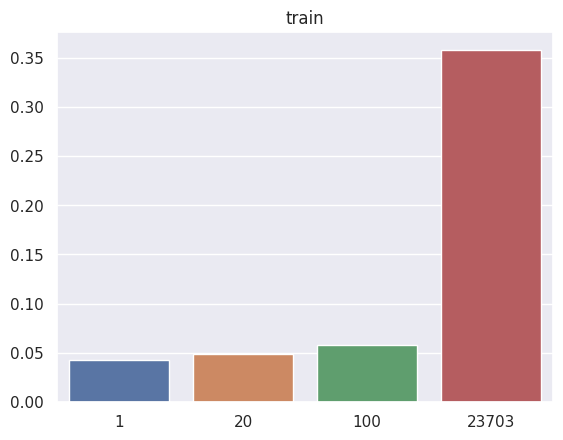

In [3]:
mb_t = [0.043, 0.049, 0.058, 0.3584]
mb_test = [0.1856, 0.1857, 0.1882, 0.3566]
b = [1, 20, 100, 23703]
sns.barplot(x=b, y=mb_t).set_title('train')

Text(0.5, 1.0, 'test')

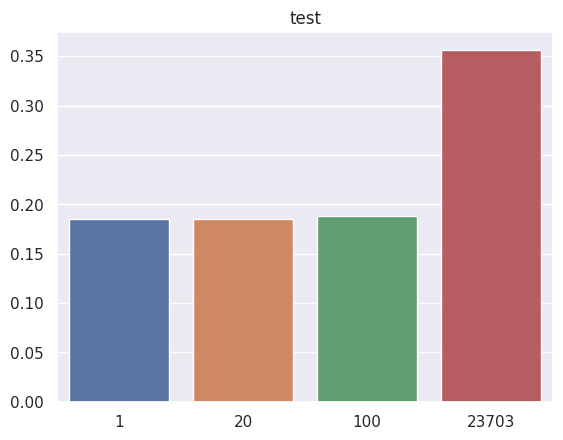

In [4]:
sns.barplot(x=b, y=mb_test).set_title('test')